In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

In [ ]:
data = pd.read_csv('exchange_rate.csv', header=0, index_col=0, parse_dates=True)

In [ ]:
data

,Ex_rate
date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


<Figure size 1500x5000 with 0 Axes>

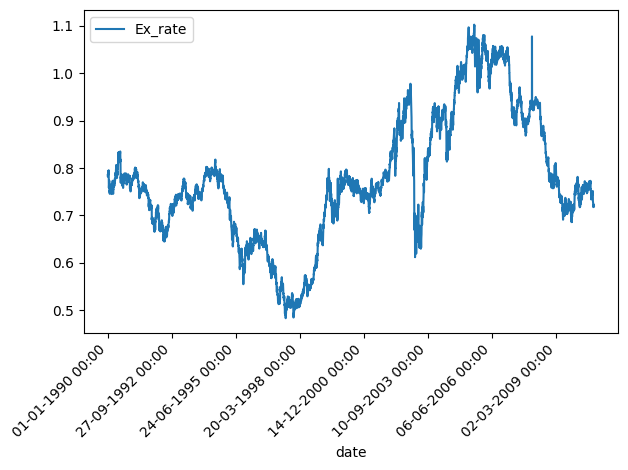

In [ ]:
# line plot of time series
plt.figure(figsize=(15,50
                ))
data.plot()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
pyplot.show()

array([[<Axes: title={'center': 'Ex_rate'}>]], dtype=object)

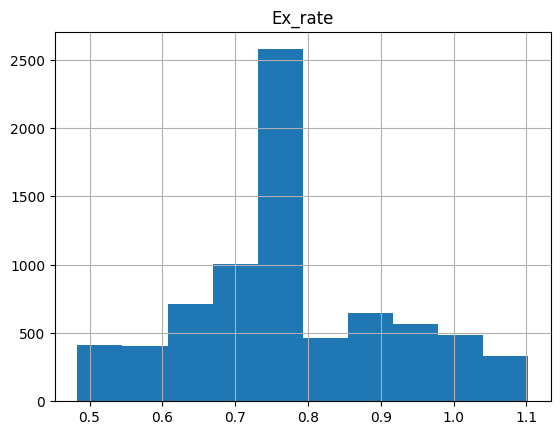

In [ ]:
data.hist()

<Axes: ylabel='Density'>

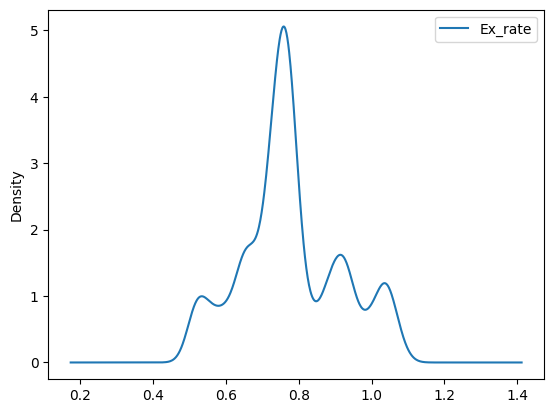

In [ ]:
data.plot(kind='kde')

Data spans from 1990 to 2009. Overall increasing trend until 2006 following which there is a decreasing trend. Data is slightly right-skewed but cannot see significant outliers. High kurtosis with peak around 0.75. Hard to determine seasonality from these graphs.

In [ ]:
print(data.index.dtype)

object


In [ ]:
data.index = pd.to_datetime(data.index, format='%d-%m-%Y %H:%M')

In [ ]:
data["month"] = data.index.strftime("%b")  # Month extraction
data["year"] = data.index.strftime("%Y")  # Year extraction

<Axes: xlabel='month', ylabel='year'>

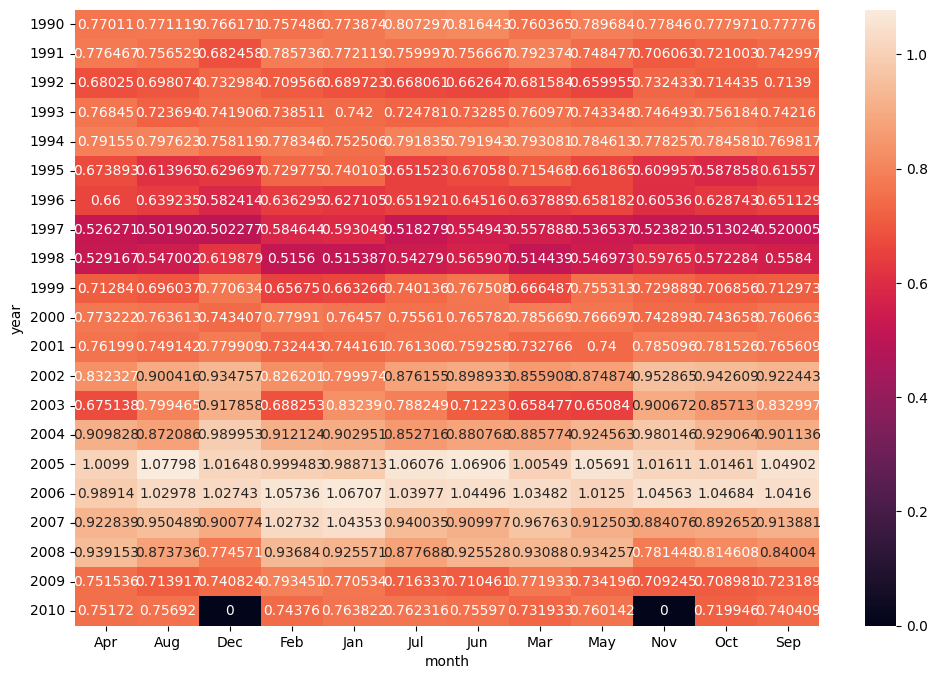

In [ ]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=data,values="Ex_rate",index="year",columns="month",aggfunc="mean",fill_value=0)

sns.heatmap(heatmap_y_month,annot=True,fmt="g")

The yearly change in trend from rising to falling is visible on the heatmap. November and December seem to show some seasonality.

In [ ]:
data.isna().sum()

,0
Ex_rate,0
month,0
year,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
 1   month    7588 non-null   object 
 2   year     7588 non-null   object 
dtypes: float64(1), object(2)
memory usage: 237.1+ KB


#Model Building - ARIMA

##Splitting into training and testing sets

In [ ]:
data

,Ex_rate,month,year
date,,,
1990-01-01,0.785500,Jan,1990
1990-01-02,0.781800,Jan,1990
1990-01-03,0.786700,Jan,1990
1990-01-04,0.786000,Jan,1990
1990-01-05,0.784900,Jan,1990
...,...,...,...
2010-10-06,0.718494,Oct,2010
2010-10-07,0.721839,Oct,2010
2010-10-08,0.723197,Oct,2010


In [ ]:
data = data.drop(columns=['month', 'year'])

In [ ]:
data

,Ex_rate
date,
1990-01-01,0.785500
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


In [ ]:
test_size = int(len(data) * 0.2)  # Calculate the size of the test set (20%)
split_point = len(data) - test_size

#Splitting into train and test
dataset, validation = data[0:split_point], data[split_point:] #dataset is training and validation is testing
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 6071, Validation 1517


##Persistence model

In [ ]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
# evaluate a persistence model
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True)

if len(train.columns) == 1:
  train = train.squeeze("columns")

# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [ ]:
# walk-forward validation
persistence_history = [x for x in train]
persistence_predictions = list()
for i in range(len(test)):
    persistence_yhat = persistence_history[-1]
    persistence_predictions.append(persistence_yhat)
# observation
    persistence_obs = test[i]
    persistence_history.append(persistence_obs)
    print('>Predicted=%.3f, Expected=%.3f' % (persistence_yhat, persistence_obs))
# report performance
rmse = sqrt(mean_squared_error(test, persistence_predictions))
print('RMSE: %.3f' % rmse)

>Predicted=0.528, Expected=0.528
>Predicted=0.528, Expected=0.530
>Predicted=0.530, Expected=0.535
>Predicted=0.535, Expected=0.534
>Predicted=0.534, Expected=0.532
>Predicted=0.532, Expected=0.534
>Predicted=0.534, Expected=0.538
>Predicted=0.538, Expected=0.538
>Predicted=0.538, Expected=0.540
>Predicted=0.540, Expected=0.539
>Predicted=0.539, Expected=0.538
>Predicted=0.538, Expected=0.544
>Predicted=0.544, Expected=0.544
>Predicted=0.544, Expected=0.544
>Predicted=0.544, Expected=0.539
>Predicted=0.539, Expected=0.538
>Predicted=0.538, Expected=0.540
>Predicted=0.540, Expected=0.535
>Predicted=0.535, Expected=0.540
>Predicted=0.540, Expected=0.540
>Predicted=0.540, Expected=0.539
>Predicted=0.539, Expected=0.539
>Predicted=0.539, Expected=0.543
>Predicted=0.543, Expected=0.544
>Predicted=0.544, Expected=0.547
>Predicted=0.547, Expected=0.548
>Predicted=0.548, Expected=0.548
>Predicted=0.548, Expected=0.549
>Predicted=0.549, Expected=0.552
>Predicted=0.552, Expected=0.556
>Predicted

##Manual Parameter Selection

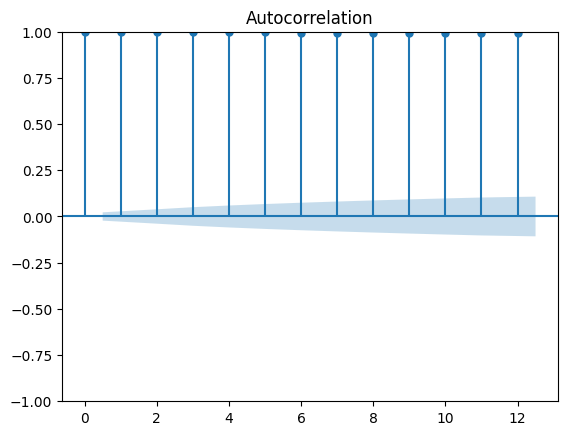

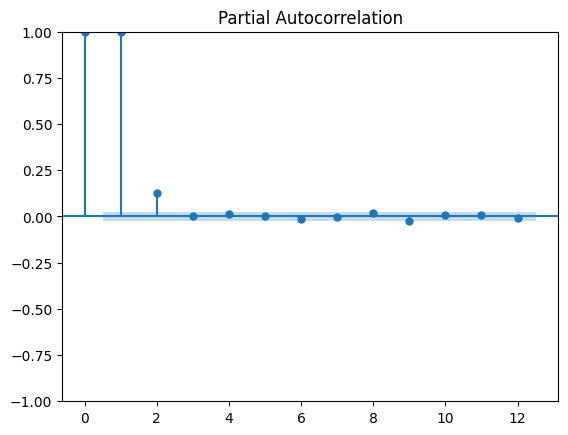

In [ ]:
#Generating ACF and pACF plots
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Ex_rate,lags=12)
tsa_plots.plot_pacf(data.Ex_rate,lags=12)
plt.show()

###Determining d value

In [ ]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.4 MB/s eta 0:00:00


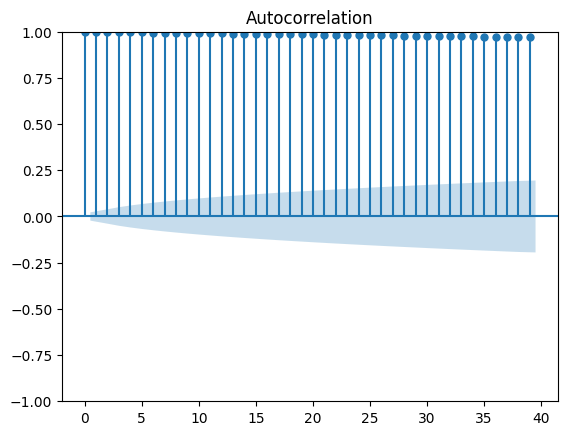

In [ ]:
#Visual Inspection and ADF Test
# Plot the ACF to visually inspect for trends or slow decay
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Ex_rate'])
plt.show()

In [ ]:
# Perform the Augmented Dickey-Fuller (ADF) test
result = adfuller(data['Ex_rate'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.664994
p-value: 0.449233
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The p-value indicates that we fail to reject the null hypothesis. Null hypothesis here is that the time series is non-stationary.

Since p value of 0.45 < 0.05 it suggests that the series is non-stationary. Hence, we must difference the data.

In [ ]:
#Using pmdarima's ndiffs function
# The output of ndiffs function directly suggests the order of differencing (d value)
d = ndiffs(data['Ex_rate'], test='adf')  # Using ADF test
print("Suggested d value:", d)

Suggested d value: 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

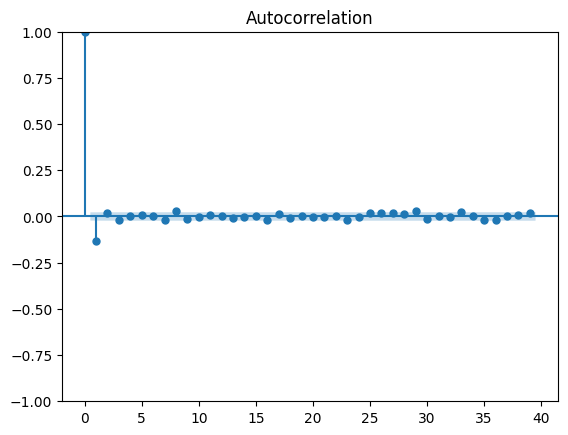

In [ ]:
#Manual Differencing and Visual Inspection
# If needed, manually difference the data and check the ACF again
data['Ex_rate_diff'] = data['Ex_rate'].diff()
plot_acf(data['Ex_rate_diff'].dropna())
plt.show()

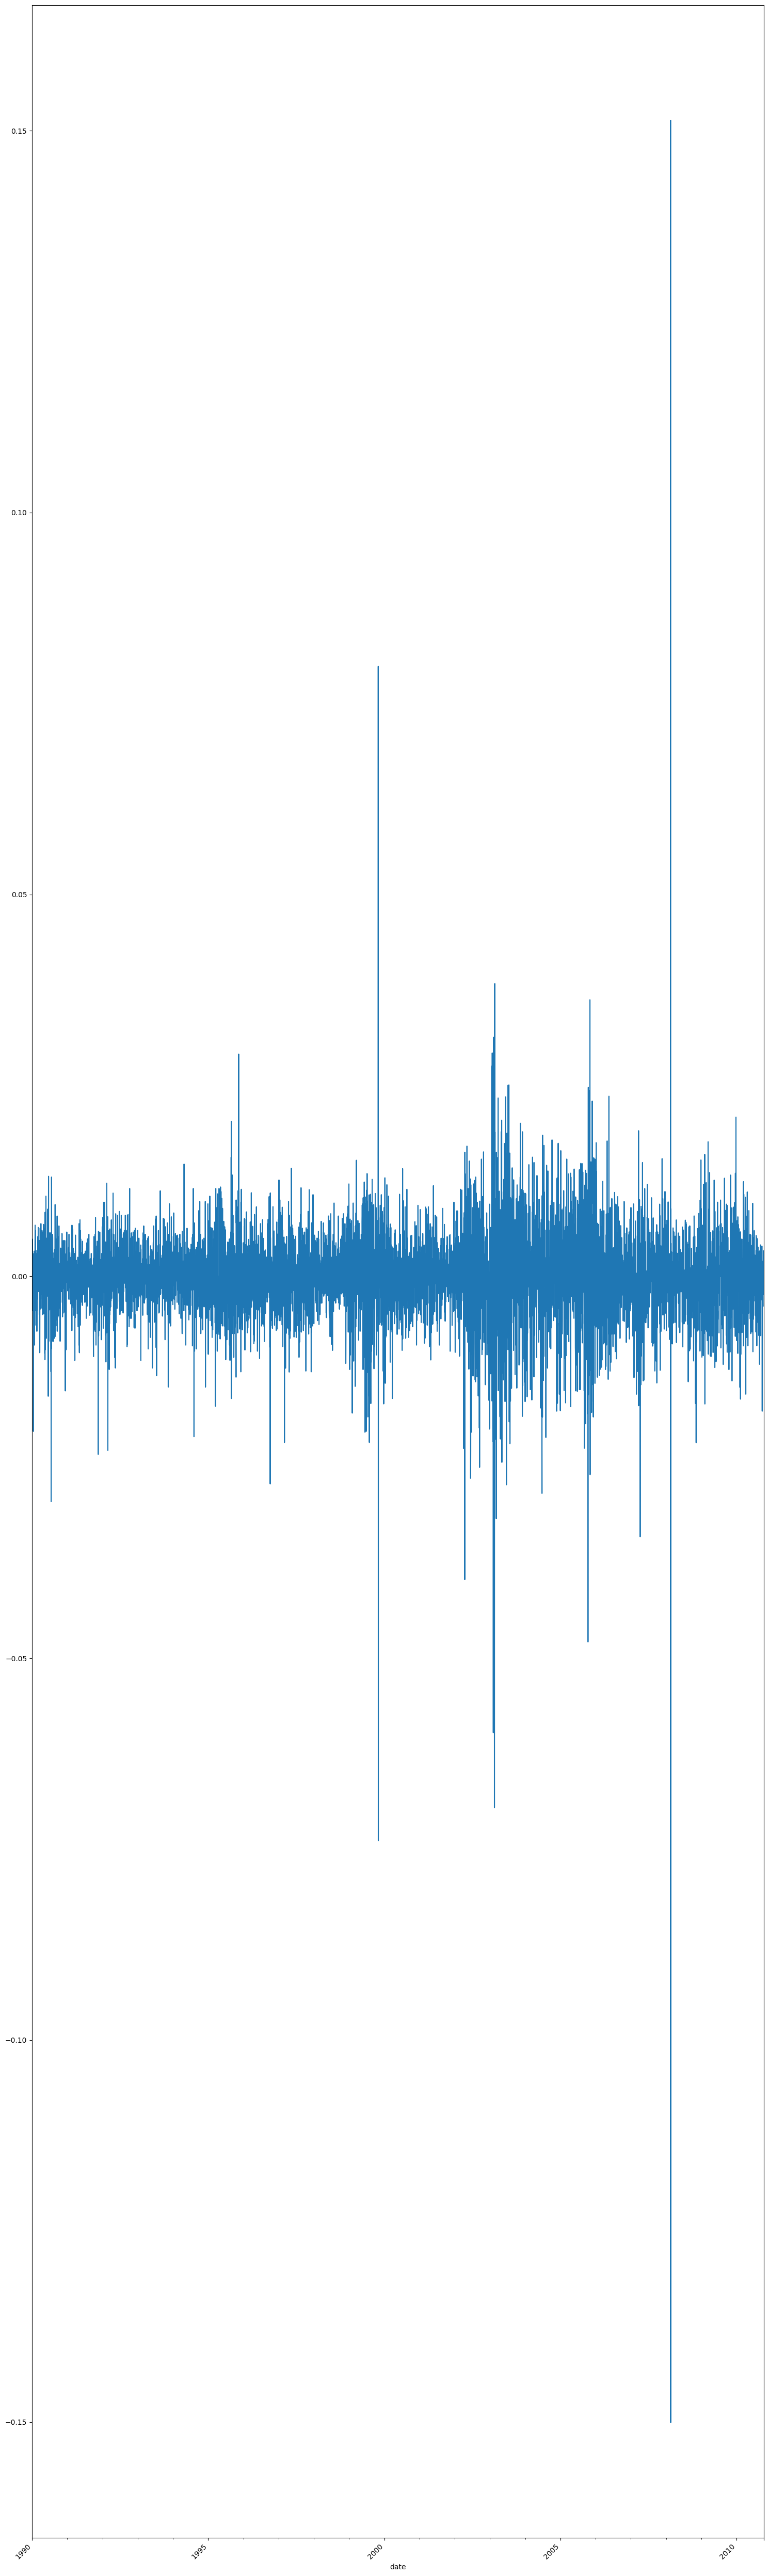

In [ ]:
# line plot of differentiated time series
plt.figure(figsize=(15,50
                ))
data['Ex_rate_diff'].plot()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
pyplot.show()

Plotted data is stationary with d=1

###Determining p and q values

In [ ]:
data_for_pq = data['Ex_rate_diff'].dropna()

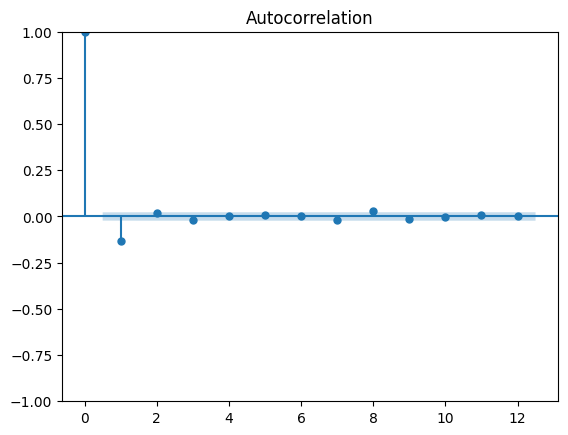

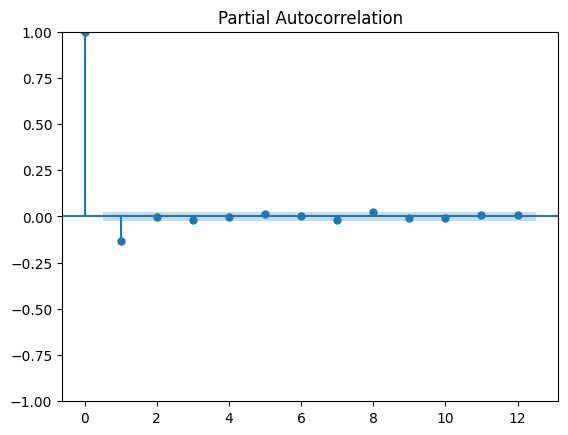

In [ ]:
tsa_plots.plot_acf(data_for_pq, lags=12)
tsa_plots.plot_pacf(data_for_pq, lags=12)
plt.show()

Inference:

1. ACF: A negative autocorrelation at lag 1 indicates that an increase in the value at the previous time step is likely to be followed by a decrease in the current time step, and vice versa. This could suggest a moving average (MA) component in the model.



2. PACF: A negative partial autocorrelation at lag 1 indicates that the correlation between the current value and the value at lag 1, after removing the effects of intermediate lags, is negative. This could suggest an autoregressive (AR) component in the model.



3. Since one line in the negatives crosses the blue line, we will use p=1 and q=1.



##ARIMA Hyperparameters

In [ ]:
import warnings
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
def evaluate_arima_model(X, arima_order):
# prepare training dataset
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]

# make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
# model_fit
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

###Gridsearch for p,d,q values

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(f"Error with ARIMA {order}: {e}") # Print error message
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
from joblib import Parallel, delayed

def evaluate_models_parallel(dataset, p_values, d_values, q_values, n_jobs=-1):
    dataset = dataset.astype('float32')
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_arima_model)(dataset, (p, d, q))
        for p in p_values
        for d in d_values
        for q in q_values
    )

    best_score = min(results)
    best_cfg = [(p, d, q) for p in p_values for d in d_values for q in q_values][results.index(best_score)]

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                rmse = results[ [(p1, d1, q1) for p1 in p_values for d1 in d_values for q1 in q_values].index(order) ]
                print('ARIMA%s RMSE=%.3f' % (order, rmse))

    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
#load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True)

if len(train.columns) == 1:
  train = train.squeeze("columns")
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models_parallel(train, p_values, d_values, q_values)

KeyboardInterrupt: 

In [ ]:
#load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True)

if len(train.columns) == 1:
  train = train.squeeze("columns")
# evaluate parameters
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(train, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.171
ARIMA(0, 0, 1) RMSE=0.089
ARIMA(0, 1, 0) RMSE=0.007
ARIMA(0, 1, 1) RMSE=0.007
ARIMA(1, 0, 0) RMSE=0.007
ARIMA(1, 0, 1) RMSE=0.007
ARIMA(1, 1, 0) RMSE=0.007
ARIMA(1, 1, 1) RMSE=0.007
Best ARIMA(1, 1, 0) RMSE=0.007


##Build model based on the optimised values

In [ ]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict

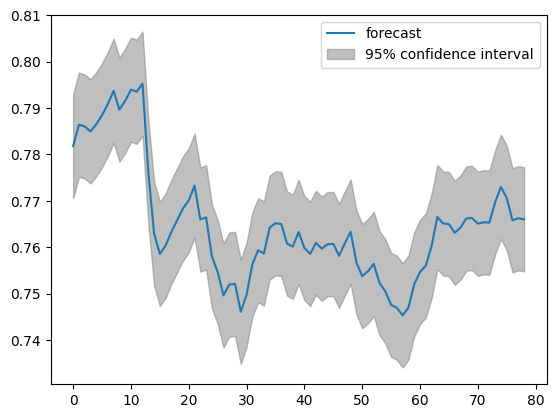

In [ ]:
# fit model
model = ARIMA(X, order=(1,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]

plot_predict(model_fit, start=1, end=79)
plt.show()


In [ ]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
forecast_values = model_fit.forecast(steps=len(val))
rmse = sqrt(mean_squared_error(val[1], forecast_values))
rmse

0.16934535144802426

In [ ]:
arima_forecast_values = forecast_values

##Combine train and test data to build final model

In [ ]:
data

,Ex_rate,Ex_rate_diff
date,,
1990-01-01,0.785500,NaN
1990-01-02,0.781800,-0.003700
1990-01-03,0.786700,0.004900
1990-01-04,0.786000,-0.000700
1990-01-05,0.784900,-0.001100
...,...,...
2010-10-06,0.718494,-0.000207
2010-10-07,0.721839,0.003345
2010-10-08,0.723197,0.001358


In [ ]:
#prepare data
X = data['Ex_rate']
X = X.astype('float32')

In [ ]:
model = ARIMA(X, order=(1,1,0))
model_fit = model.fit()

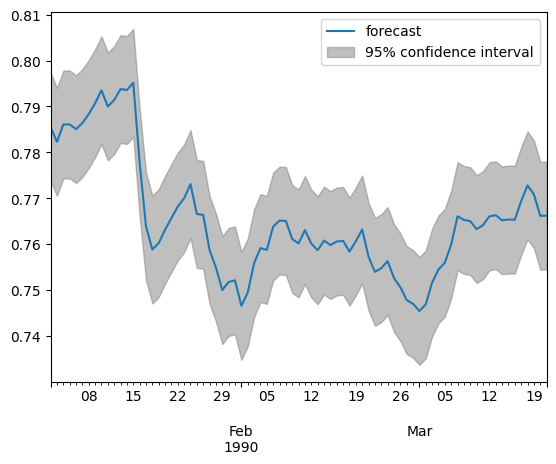

In [ ]:
forecast=model_fit.forecast(steps=10)[0]
plot_predict(model_fit, start=1, end=79)
plt.show()

##Diagnostics - Residual Analysis

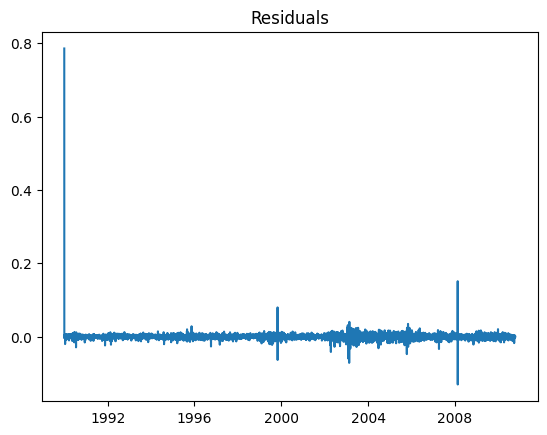

In [ ]:
residuals = model_fit.resid

# Plot residuals
plt.plot(residuals)
plt.title('Residuals')
plt.show()

Plot the Residuals: There are no patterns or trends in the plot. Since the residuals are randomly scattered around zero, this is ideal and indicates that the model has captured most of the underlying patterns in the data.

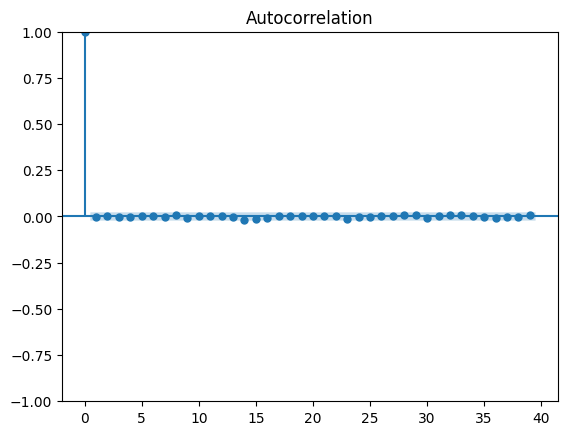

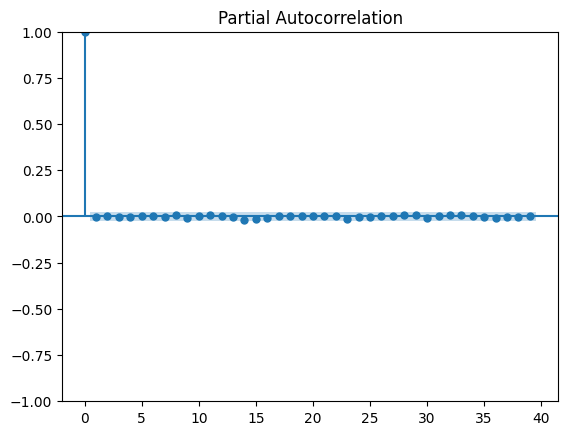

In [ ]:
# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals)
plot_pacf(residuals)
plt.show()

Check for Autocorrelation: Since there are no significant autocorrelations, the model has fully captured the temporal dependencies in the data.

##Forecasting

In [ ]:
forecast_horizon = 12
forecast = model_fit.forecast(steps=forecast_horizon)
forecast_values = forecast

In [ ]:
forecast_values

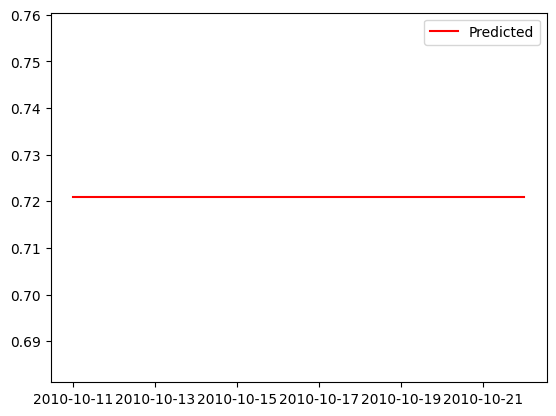

In [ ]:
plt.plot(forecast_values, color='red', label='Predicted')
plt.legend()
plt.show()

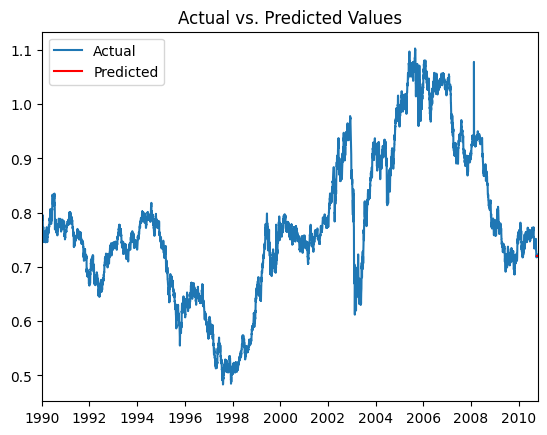

In [ ]:
# Get the last date in the actual data
last_actual_date = data.index[-1]
plot_start_date = data.index[0]  # Start from the beginning of the actual data
plot_end_date = last_actual_date + pd.DateOffset(days=forecast_horizon)  # Extend by forecast_horizon days

plt.plot(data['Ex_rate'], label='Actual')
plt.plot(forecast_values, color="red", label='Predicted')
plt.xlim(plot_start_date, plot_end_date)  # Extend the x-axis to include the forecast
plt.legend()
plt.title('Actual vs. Predicted Values')
plt.show()

Red line is a little hard to visualize because of scale but it is there

#Model-Building : Exponential Smoothing

##Model Selection

###Time series decomposition plot

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

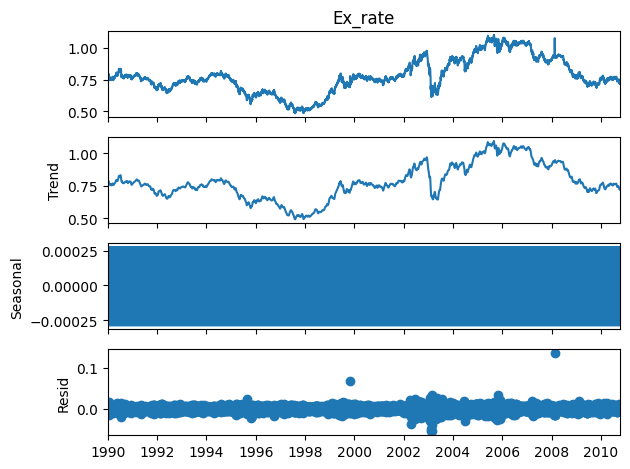

In [ ]:
decompose_ts_add = seasonal_decompose(data.Ex_rate,period=12)
decompose_ts_add.plot()
plt.show()

The presence of a clear trend is confirmed. Seasonal patterns are not detetcted.

We shall implement Holt's method since trend is present.

###Evaluation metric MAPE

In [ ]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

###Building Smoothing model

In [ ]:
from statsmodels.tsa.holtwinters import Holt

In [ ]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
test = read_csv('validation.csv', header=0, index_col=0, parse_dates=True)

X = train.iloc[:, 0]
X = X.astype('float32')

In [ ]:
X

,0.7855
1990-01-01,
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
1990-01-06,0.786600
...,...
2006-08-11,1.027591
2006-08-12,1.022349
2006-08-13,1.023395


In [151]:
# Holt method
hw_model = Holt(X).fit()
start_date = pd.Timestamp('2006-08-16')
pred_hw = hw_model.predict(start=start_date,end = test.index[-1])
MAPE(pred_hw,test.iloc[:, 0])

0.3997396040006504

In [152]:
smoothed_forecast_values = pred_hw

###Final Model by combining train and test

In [ ]:
# Apply Holt's linear smoothing to the entire dataset
X = data['Ex_rate'].astype('float32')
hw_model = Holt(X).fit()

In [ ]:
# Forecast for the next 12 time periods
forecast_horizon = 12
forecast_values = hw_model.predict(start=data.index[-1] + pd.DateOffset(days=1),  # Start from the next day
                                    end=data.index[-1] + pd.DateOffset(days=forecast_horizon))

In [ ]:
print(forecast_values)

2010-10-11    0.720590
2010-10-12    0.720354
2010-10-13    0.720118
2010-10-14    0.719882
2010-10-15    0.719646
2010-10-16    0.719410
2010-10-17    0.719174
2010-10-18    0.718938
2010-10-19    0.718702
2010-10-20    0.718466
2010-10-21    0.718230
2010-10-22    0.717994
Freq: D, dtype: float64


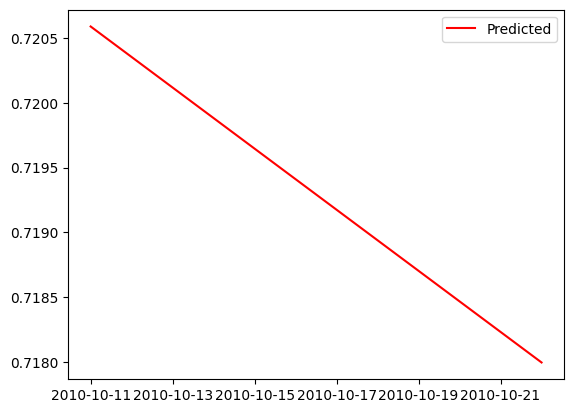

In [ ]:
plt.plot(forecast_values, color='red', label='Predicted')
plt.legend()
plt.show()

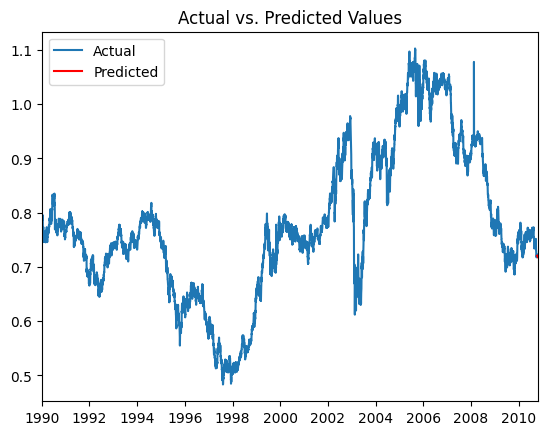

In [ ]:
# Get the last date in the actual data
last_actual_date = data.index[-1]
plot_start_date = data.index[0]  # Start from the beginning of the actual data
plot_end_date = last_actual_date + pd.DateOffset(days=forecast_horizon)  # Extend by forecast_horizon days

plt.plot(data['Ex_rate'], label='Actual')
plt.plot(forecast_values, color="red", label='Predicted')
plt.xlim(plot_start_date, plot_end_date)  # Extend the x-axis to include the forecast
plt.legend()
plt.title('Actual vs. Predicted Values')
plt.show()

#Comparing metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
arima_forecast_values

,predicted_mean
2010-10-11,0.720825
2010-10-12,0.720825
2010-10-13,0.720825
2010-10-14,0.720825
2010-10-15,0.720825
...,...
2014-12-01,0.720825
2014-12-02,0.720825
2014-12-03,0.720825
2014-12-04,0.720825


In [ ]:
actual_values = val[1].values

In [ ]:
arima_mae = mean_absolute_error(actual_values, arima_forecast_values)
arima_mape = MAPE(arima_forecast_values, actual_values)
arima_rmse = np.sqrt(mean_squared_error(actual_values, arima_forecast_values))

# Print the results
print("ARIMA Model:")
print("MAE:", arima_mae)
print("MAPE:", arima_mape)
print("RMSE:", arima_rmse)

ARIMA Model:
MAE: 0.1312739853805235
MAPE: 14.109720752539241
RMSE: 0.16934535144802426


In [144]:
validation

,Ex_rate
date,
2006-08-16,1.026905
2006-08-17,1.037344
2006-08-18,1.038875
2006-08-19,1.032855
2006-08-20,1.033293
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


In [153]:
smoothed_forecast_values

,0
2006-08-16,1.025047
2006-08-17,1.026624
2006-08-18,1.035985
2006-08-19,1.038564
2006-08-20,1.033627
...,...
2010-10-06,0.718521
2010-10-07,0.718232
2010-10-08,0.721129
2010-10-09,0.722705


In [ ]:
actual_values

array([1.026905, 1.037344, 1.038875, ..., 0.723197, 0.720825, 0.720825])

In [154]:
smoothed_forecast_values_array = smoothed_forecast_values.values.flatten()

In [155]:
smoothed_forecast_values_array

array([1.02504661, 1.02662434, 1.03598545, ..., 0.72112923, 0.72270477,
       0.72083532])

In [156]:
# Calculate error metrics for Smoothed model
smoothed_mae = mean_absolute_error(actual_values, smoothed_forecast_values_array)  # Use the array
smoothed_mape = MAPE(smoothed_forecast_values_array, actual_values)
smoothed_rmse = np.sqrt(mean_squared_error(actual_values, smoothed_forecast_values_array))

print("\nSmoothed Model:")
print("MAE:", smoothed_mae)
print("MAPE:", smoothed_mape)
print("RMSE:", smoothed_rmse)


Smoothed Model:
MAE: 0.003355762604413961
MAPE: 0.3995953919427134
RMSE: 0.006920351320220333


###ARIMA Model:

MAE: 0.1312739853805235

MAPE: 14.109720752539241

RMSE: 0.16934535144802426


###Smoothed Model:

MAE: 0.003355762604413961

MAPE: 0.3995953919427134

RMSE: 0.006920351320220333

###Values of MAE, MAPE and RMSE are significantly lower in the smoothed model compared to the ARIMA model. Hence the smoothed model provided the best performance in forecasting exchange ranges on this dataset.


###Advantages and Limitations

####Smoothed Model (Exponential Smoothing)

Advantages:

Simplicity: Often easier to implement and understand than ARIMA.
Good for Trend and Seasonality: Well-suited for time series data with clear trends and seasonality patterns.
Handles Noise: Can handle noisy data relatively well.
Efficient for Forecasting: Can be computationally efficient for forecasting.
Limitations:

Limited Complexity: Might not capture complex patterns or relationships in the data as effectively as ARIMA.
Assumes Smoothness: May not perform well with data that exhibits abrupt changes or irregularities.

####ARIMA Model

Advantages:

Flexibility: Can model a wide range of time series patterns, including complex dependencies.
Stationarity: Explicitly handles stationarity, making it suitable for data with varying statistical properties over time.
Statistical Rigor: Based on a well-established statistical framework.
Limitations:

Complexity: Can be more difficult to implement and tune compared to Exponential Smoothing.
Data Requirements: Requires careful data preprocessing, including differencing and stationarity checks.
Computational Cost: Can be computationally intensive for large datasets or complex models.